## Background

This implementation is based on the article https://arxiv.org/abs/2203.11882. It is a special case when setting unitary gate $U$ in the paper as $X$ gate.
<br> To decompose $C^nX$, we need $(n + 1)$ quantum registers. We need to break down controlled $RX$ gate and controlled phase gate into $CX$ and $U$ gates. This works is done in the "Building blocks" part. The final implementation of $C^nX$ gate is based on FIG. 1 in this artical, rather than the formula given by Eq (3).

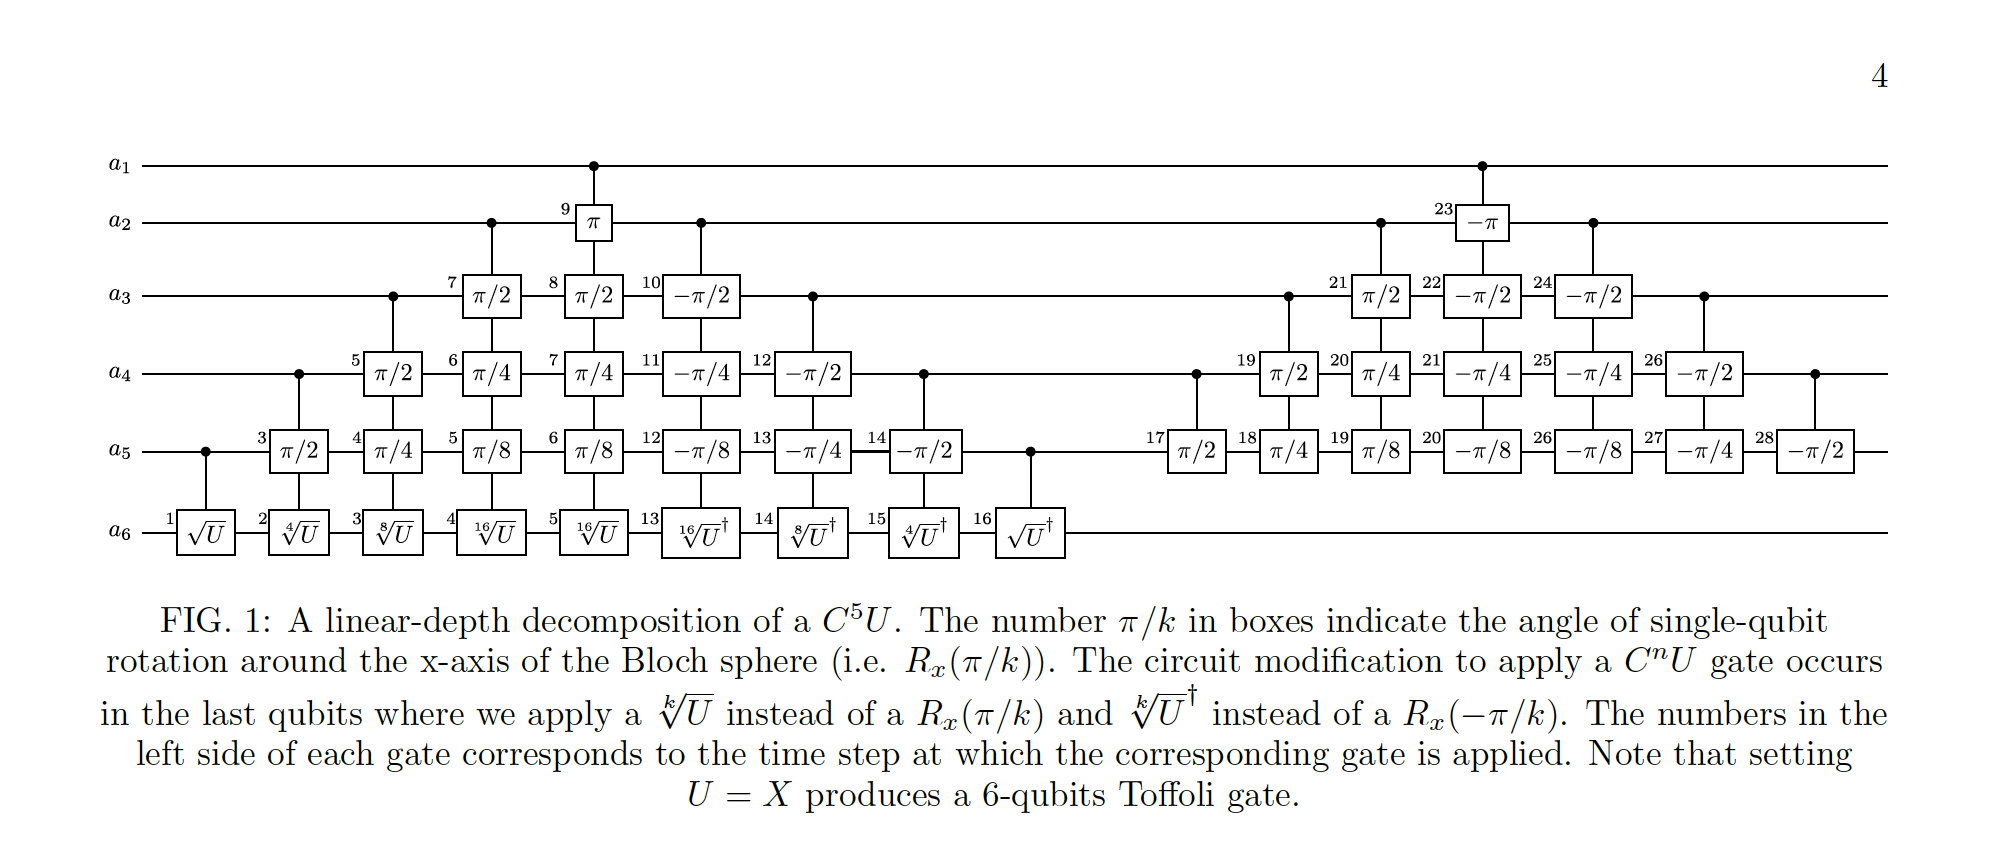

## Building blocks

In [123]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import XGate, SGate, TGate, SXGate, CRXGate, CPhaseGate

### implement H gate using U gate

In [166]:
# H = U(pi/2, 0, pi)
def add_h(qc, register):
    qc.u(np.pi/2, 0, np.pi, register)

### implement contolled RX gate using CX and U gates

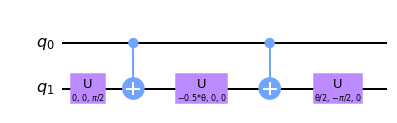

In [147]:
# for any angle theta
theta = Parameter('θ')

qc1 = QuantumCircuit(2)
qc1.u(0, 0, np.pi/2, 1)
qc1.cx(0, 1)
qc1.u(-theta/2, 0, 0, 1)
qc1.cx(0, 1)
qc1.u(theta/2, -np.pi/2, 0, 1)

qc1.draw('mpl')

In [52]:
# verify it is correct
# input any theta
theta = np.pi / 3
qc1_test = QuantumCircuit(2)
qc1_test.u(0, 0, np.pi/2, 1)
qc1_test.cx(0, 1)
qc1_test.u(-theta/2, 0, 0, 1)
qc1_test.cx(0, 1)
qc1_test.u(theta/2, -np.pi/2, 0, 1)
assert(Operator(qc1_test) == Operator(CRXGate(theta)))

# write it as a function
def add_crx(qc, theta, control, target):
    qc.u(0, 0, np.pi/2, target)
    qc.cx(control, target)
    qc.u(-theta/2, 0, 0, target)
    qc.cx(control, target)
    qc.u(theta/2, -np.pi/2, 0, target)

### implement roots of X gate using U gate

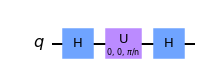

In [56]:
# since X = HZH, X^(1/n) = H * Z^(1/n) * H = H * P(pi/n) * H
# and P(pi/n) = U(0, 0, pi/n) or U(0, pi/n, 0)

# for any positive integer as n
n = Parameter('n')

# so the n-th root of X gate is implemented as
qc2 = QuantumCircuit(1)
qc2.h(0)
qc2.u(0, 0, np.pi/n, 0)
qc2.h(0)
qc2.draw('mpl')

In [125]:
# verify it is correct
# input any n
n = 5

qc2_test = QuantumCircuit(1)
for _ in range(n):
    qc2_test.h(0)
    qc2_test.u(0, 0, np.pi/n, 0)
    qc2_test.h(0)

# apply the previous block n times, get us X gate
assert(Operator(qc2_test) == Operator(XGate()))

### implement controlled roots of X gate using CX and U gates

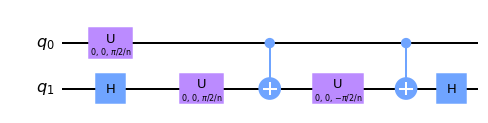

In [136]:
# for any angle alpha
alpha = Parameter('α')

# for controlled phase gate p with angle alpha, can be implemented as
qc4 = QuantumCircuit(2)
qc4.p(alpha/2, [0, 1])
qc4.cx(0, 1)
qc4.p(-alpha/2, 1)
qc4.cx(0, 1)
qc4.draw('mpl')

# since p(alpha) = u(0, 0, alpha) and use the previous implementation of roots of X gate
# we only need to apply H gates at the beginning and the end

# for any positive integer as n
n = Parameter('n')
# set alpha = pi/n, put everything together
qc5 = QuantumCircuit(2)
qc5.h(1)
qc5.u(0, 0, np.pi/(2*n), [0, 1])
qc5.cx(0, 1)
qc5.u(0, 0, -np.pi/(2*n), 1)
qc5.cx(0, 1)
qc5.h(1)
qc5.draw('mpl')

However, using controlled $\sqrt[n]{X}$ gate is redundant, in the bottom register of the graph (FIG. 1), the $H$ gates cancel each other.
<br> So the problem becomes applying controlled $\sqrt[n]{Z}$ gate, with $H$ gates applied at the beginning and the end.
<br> Moreover, since $Z = \text{Phase}(\pi)$ and $Z^k = \text{Phase}(k \pi)$, it is sufficient to apply controlled phase gates in the circuit

In [168]:
# write it as a function
def add_cp(qc, alpha, control, target):
    qc.u(0, 0, alpha/2, [control, target])
    qc.cx(control, target)
    qc.u(0, 0, -alpha/2, target)
    qc.cx(control, target)

def add_crootx(qc, n, control, target):
    qc.h(target)
    qc.u(0, 0, np.pi/(2*n), [control, target])
    qc.cx(control, target)
    qc.u(0, 0, -np.pi/(2*n), target)
    qc.cx(control, target)
    qc.h(target)
    
def add_crootz(qc, n, control, target):
    qc.u(0, 0, np.pi/(2*n), [control, target])
    qc.cx(control, target)
    qc.u(0, 0, -np.pi/(2*n), target)
    qc.cx(control, target)
    
# verify it is correct
qc3_test = QuantumCircuit(2)
alpha = np.pi/7
add_cp(qc3_test, alpha, 0, 1)

assert(Operator(qc3_test) == Operator(CPhaseGate(alpha)))

## Put together

Base on FIG. 1, the circuits consists of two "triangle"s. The difference of the two triangles are:
<br> 1) the first triangle has controlled $\sqrt[2^k]{X}$ gates (in this task) on the target register, where $k \in \mathbb{Z}^+$
<br> 2) the angles in these triangles are different
<br>
<br> Except for adding controlled phase gates in the first triangle, the implementations of the two triangles are the same

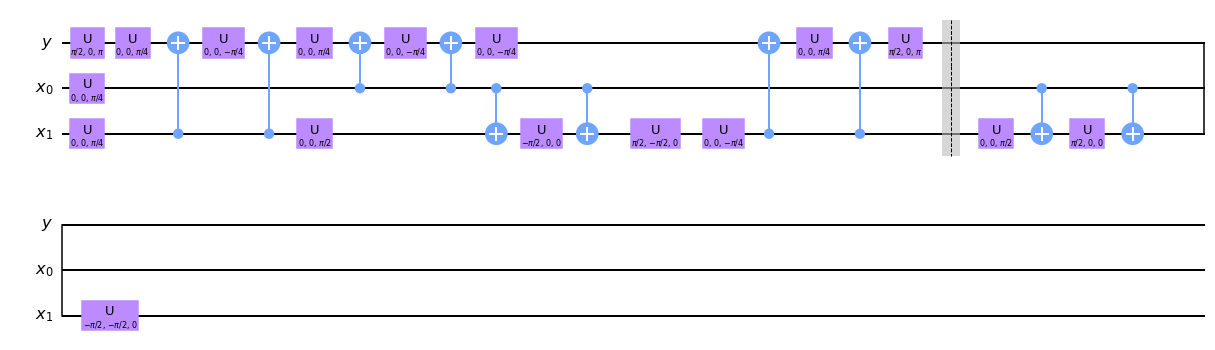

In [172]:
# n is the number of controlled registers
n = 2

qr_control = QuantumRegister(n, 'x')
qr_target = QuantumRegister(1, 'y')
# set target at the zeroth register
qc = QuantumCircuit(qr_target, qr_control)

# apply the beginning h gate on target register
add_h(qc, 0)

# left side of the first triangle (without the gates in the middle)
for i, q in enumerate(reversed(qr_control[1:])):
    for j, p in enumerate(qr_control[n - i:]):
        # for each control register, apply crx gates at higher indexed registers
        add_crx(qc, np.pi * np.exp2(-(j + 1)), q, p)
    
    # apply controlled phase gates on target register
    add_cp(qc, np.pi * np.exp2(-(i + 1)), q, 0)
    
# add the last gate of the middle line
add_cp(qc, np.pi * np.exp2(-n + 1), qr_control[0], 0)

# right side of the first triangle
for i, q in enumerate(qr_control[1:]):
    # gates in the middle  
    add_crx(qc, np.pi * np.exp2(-i), qr_control[0], q)
    
    for j, p in enumerate(qr_control[i + 2:]):
        # for each control register, apply crx gates at higher indexed registers
        add_crx(qc, -np.pi * np.exp2(-(j + 1)), q, p)   
    
    # apply controlled phase gates on target register
    add_cp(qc, -np.pi * np.exp2(i - n + 1), q, 0)

# apply the end h gate on target register
add_h(qc, 0)

# end of the first triangle
qc.barrier()

# left side of the second triangle (without the gates in the middle)
for i, q in enumerate(reversed(qr_control[1:])):
    for j, p in enumerate(qr_control[n - i:]):
        # for each control register, apply crx gates at higher indexed registers
        add_crx(qc, np.pi * np.exp2(- (j + 1)), q, p)


# right side of the second triangle
for i, q in enumerate(qr_control[1:]):
    # gates in the middle
    add_crx(qc, -np.pi * np.exp2(-i), qr_control[0], q)
    for j, p in enumerate(qr_control[i + 2:]):
        # for each control register, apply crx gates at higher indexed registers
        add_crx(qc, -np.pi * np.exp2(- (j + 1)), q, p)
    
qc.draw('mpl')

In [173]:
print(np.round(np.array(Operator(qc)), 2))

[[ 1.-0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.-0.j -0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.-0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.-0.j -0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j  0.+0.j  1.-0.j -0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j  1.-0.j -0.+0.j]]
